In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import cv2
import tqdm

In [2]:
import os, shutil, pathlib

In [3]:
IMAGE_SIZE = (150, 150, 3)

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "train",
    seed=123,
    image_size=(150, 150),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "test",
    seed=123,
    image_size=(150, 150),
    batch_size=32)

Found 1594 files belonging to 2 classes.
Found 394 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names

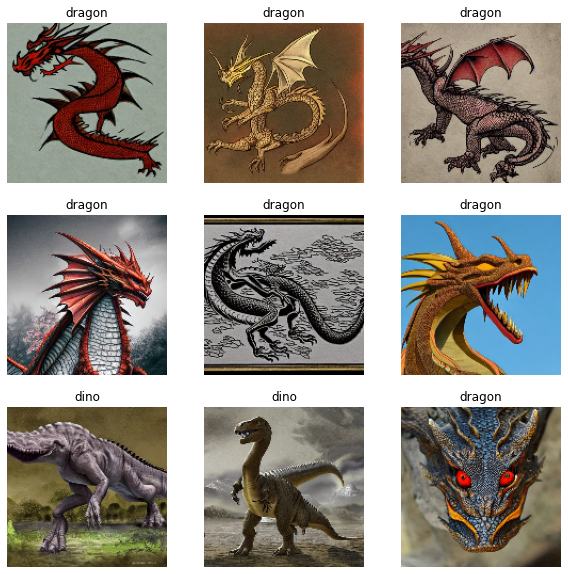

In [6]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
train_dir = os.path.join(os.getcwd(),"train")

for class_, folder in zip(class_names, os.listdir(train_dir)):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(f"class {class_}: {len(files_path)}")

class dino: 827
class dragon: 767


In [8]:
# assign class labels
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

{'dino': 0, 'dragon': 1}


### Data Standardization (Not used for model fitting)

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_train = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_validation = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

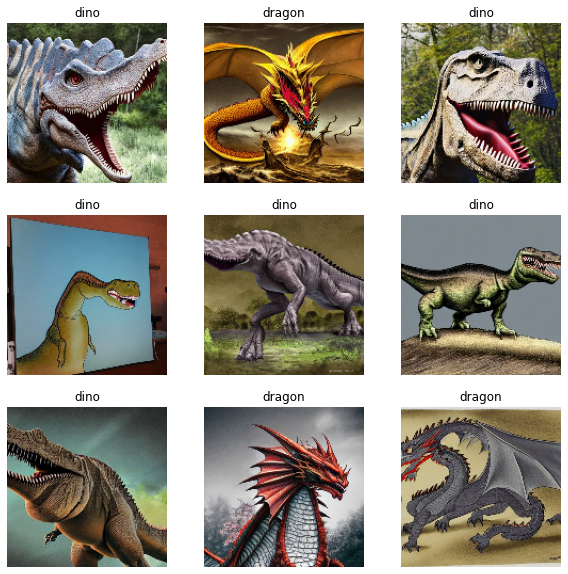

In [10]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
 
for images, labels in normalized_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

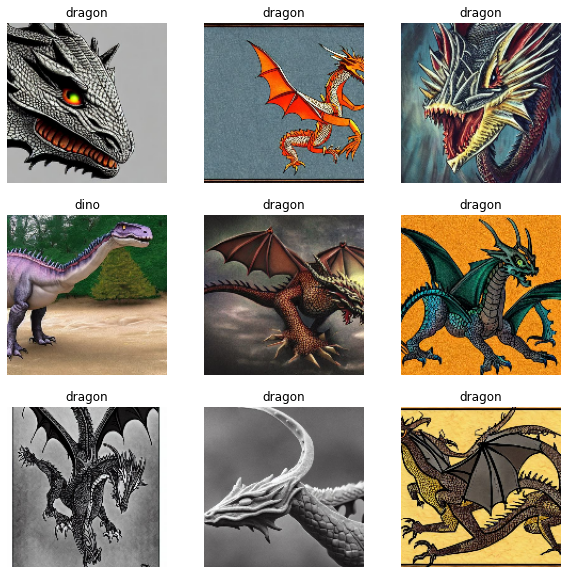

In [11]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))

for images, labels in normalized_validation.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
train_image_batch, train_labels_batch = next(iter(normalized_train))
val_image_batch, val_labels_batch = next(iter(normalized_validation))

first_image = train_image_batch[0]
second_image = val_image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(np.min(second_image), np.max(second_image))

0.0 1.0
0.0 0.99272007


### Building Neural Network Model from Scratch

Develop a CNN-based model with following structure:

- The shape for input should be `(150, 150, 3)`
- Next, create a convolutional layer (`Conv2D`):
    - Use 32 filters
    - Kernel size should be `(3, 3)` (that's the size of the filter)
    - Use `relu` as activation
- Reduce the size of the feature map with max pooling (`MaxPooling2D`)
    - Set the pooling size to `(2, 2)`
- Turn the multi-dimensional result into vectors using a `Flatten` layer
- Next, add a `Dense` layer with 64 neurons and '`relu`' activation
- Finally, create the `Dense` layer with 1 neuron - this will be the output
    - The output layer should have an activation - use the appropriate activation for the binary classification case

As optimizer use `SGD` with the following parameters:

    SGD(lr=0.002, momentum=0.8)


In [16]:
def make_model():

    inputs = keras.Input(shape=(150, 150, 3))
    conv_layer1 = layers.Conv2D(filters = 32, kernel_size=3, activation="relu")(inputs)  
    pool_layer1 = layers.MaxPooling2D(pool_size=2)(conv_layer1)
    flatten_layer = layers.Flatten()(pool_layer1)
    dense_layer = layers.Dense(64, activation="relu")(flatten_layer)
    outputs = layers.Dense(1, activation="sigmoid")(dense_layer)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.SGD(
        learning_rate=0.002, momentum=0.8
    )
    loss = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"])

    return model

In [17]:
model = make_model()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 175232)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                11214912  
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                           

In [19]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=10, batch_size=32
    )

Epoch 1/10
50/50 [==============================] - 3s 37ms/step - loss: 732.2803 - accuracy: 0.5169 - val_loss: 0.6934 - val_accuracy: 0.4975
Epoch 2/10
50/50 [==============================] - 2s 32ms/step - loss: 0.6927 - accuracy: 0.5188 - val_loss: 0.6934 - val_accuracy: 0.4975
Epoch 3/10
50/50 [==============================] - 2s 33ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6935 - val_accuracy: 0.4975
Epoch 4/10
50/50 [==============================] - 2s 34ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6935 - val_accuracy: 0.4975
Epoch 5/10
50/50 [==============================] - 2s 31ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6936 - val_accuracy: 0.4975
Epoch 6/10
50/50 [==============================] - 2s 33ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6937 - val_accuracy: 0.4975
Epoch 7/10
50/50 [==============================] - 2s 32ms/step - loss: 0.6925 - accuracy: 0.5188 - val_loss: 0.6937 - val_accuracy: 0.4975
Epoch 8/10


In [22]:
X, y = next(iter(train_dataset))

In [23]:
y

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1])>

### Question 1

Since we have a binary classification problem, what is the best loss function for us?

#### Answer: binary crossentropy

Note: since we specify an activation for the output layer, we don't need to set from_logits=True

### Question 2

What's the total number of parameters of the model? You can use the summary method for that.

#### Answer: 11215873



### Generators and Training

For the next two questions, use the following data generator for both train and validation:
```
ImageDataGenerator(rescale=1./255)
```
- We don't need to do any additional pre-processing for the images.
- When reading the data from train/val directories, check the `class_mode` parameter. Which value should it be for a binary classification problem?
- Use `batch_size=20`
- Use `shuffle=True` for both training and validation


In [79]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
)

val_ds = val_gen.flow_from_directory(
    'test',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
    
)

Found 1594 images belonging to 2 classes.
Found 394 images belonging to 2 classes.


In [80]:
X, y = next(train_ds)

In [81]:
X[:1]

array([[[[0.28235295, 0.28235295, 0.27450982],
         [0.227451  , 0.227451  , 0.21960786],
         [0.28235295, 0.28235295, 0.27450982],
         ...,
         [0.26666668, 0.26666668, 0.26666668],
         [0.28235295, 0.28235295, 0.28235295],
         [0.24313727, 0.24313727, 0.24313727]],

        [[0.2627451 , 0.2627451 , 0.25490198],
         [0.27058825, 0.27058825, 0.2627451 ],
         [0.30980393, 0.30980393, 0.3019608 ],
         ...,
         [0.2509804 , 0.2509804 , 0.2509804 ],
         [0.2784314 , 0.2784314 , 0.2784314 ],
         [0.27450982, 0.27450982, 0.27450982]],

        [[0.2509804 , 0.2509804 , 0.24313727],
         [0.27450982, 0.27450982, 0.26666668],
         [0.29411766, 0.29411766, 0.28627452],
         ...,
         [0.32156864, 0.32156864, 0.32156864],
         [0.30980393, 0.30980393, 0.30980393],
         [0.25490198, 0.25490198, 0.25490198]],

        ...,

        [[0.56078434, 0.5372549 , 0.43529415],
         [0.62352943, 0.6       , 0.49803925]

In [82]:
y

array([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1.], dtype=float32)

In [83]:
history.epoch[-1] 

9

In [84]:
model_2 = make_model()

In [85]:
with tf.device("/device:GPU:0"):
    history2 = model_2.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
    )

Epoch 1/10
80/80 [==============================] - 7s 84ms/step - loss: 0.6037 - accuracy: 0.6844 - val_loss: 0.5307 - val_accuracy: 0.7183
Epoch 2/10
80/80 [==============================] - 6s 80ms/step - loss: 0.4482 - accuracy: 0.8080 - val_loss: 0.4126 - val_accuracy: 0.8274
Epoch 3/10
80/80 [==============================] - 6s 81ms/step - loss: 0.3791 - accuracy: 0.8450 - val_loss: 0.3821 - val_accuracy: 0.8477
Epoch 4/10
80/80 [==============================] - 6s 80ms/step - loss: 0.3181 - accuracy: 0.8745 - val_loss: 0.3214 - val_accuracy: 0.8579
Epoch 5/10
80/80 [==============================] - 6s 81ms/step - loss: 0.2866 - accuracy: 0.8871 - val_loss: 0.3007 - val_accuracy: 0.8782
Epoch 6/10
80/80 [==============================] - 6s 79ms/step - loss: 0.2652 - accuracy: 0.9021 - val_loss: 0.3643 - val_accuracy: 0.8299
Epoch 7/10
80/80 [==============================] - 6s 81ms/step - loss: 0.2486 - accuracy: 0.9015 - val_loss: 0.3077 - val_accuracy: 0.8604
Epoch 8/10
80

In [86]:
np.median(history2.history['accuracy'], axis=0)   

0.8942911028862

In [87]:
np.std(history2.history['loss'])

0.13048792983230245

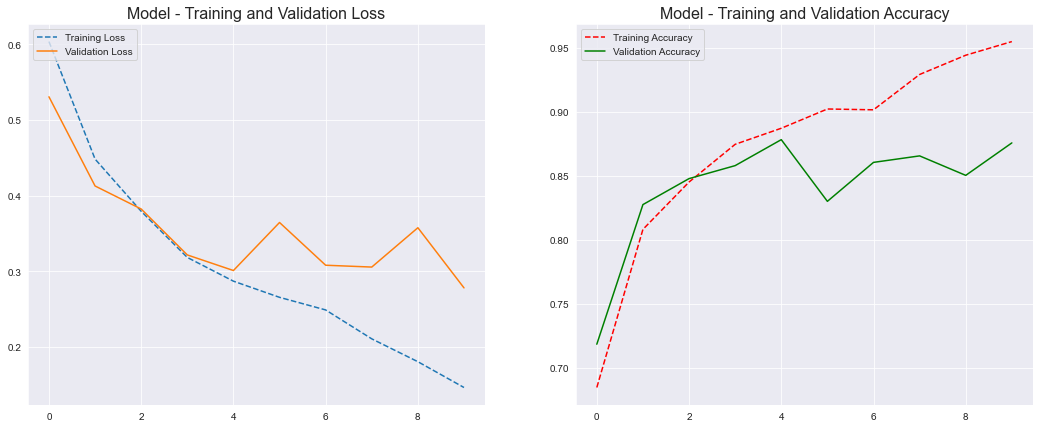

In [88]:
import seaborn as sns
sns.set_style('darkgrid')

## Generate visualization 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7))
ax1.plot(history2.history['loss'], label='Training Loss', linestyle="--")
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.set_title('Model - Training and Validation Loss', size=16)
ax1.legend(loc="upper left")
ax2.plot(history2.history['accuracy'], label='Training Accuracy', linestyle="--", color='r')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='g')
ax2.set_title('Model - Training and Validation Accuracy', size=16)
ax2.legend(loc="upper left")
plt.show()

### Question 3

What is the median of training accuracy for all the epochs for this model?

#### Answer: 0.89429 - > 0.90



### Question 4

What is the standard deviation of training loss for all the epochs for this model?

#### Answer: 0.13048 -> 0.11

### Data Augmentation

For the next two questions, we'll generate more data using data augmentations.

Add the following augmentations to your training data generator:

    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'


In [89]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [90]:
train_ds = train_gen.flow_from_directory(
    'train',
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode="sparse"
)

Found 1594 images belonging to 2 classes.


In [91]:
history2.epoch[-1] 

9

In [92]:
with tf.device("/device:GPU:0"):
    history3 = model_2.fit(
        train_ds,
        validation_data=val_ds,
        epochs=20,
        initial_epoch=history2.epoch[-1]+1
    )

Epoch 11/20
80/80 [==============================] - 18s 223ms/step - loss: 0.4217 - accuracy: 0.8087 - val_loss: 0.4336 - val_accuracy: 0.8071
Epoch 12/20
80/80 [==============================] - 17s 214ms/step - loss: 0.4044 - accuracy: 0.8168 - val_loss: 0.3236 - val_accuracy: 0.8579
Epoch 13/20
80/80 [==============================] - 17s 215ms/step - loss: 0.3887 - accuracy: 0.8312 - val_loss: 0.3658 - val_accuracy: 0.8173
Epoch 14/20
80/80 [==============================] - 18s 223ms/step - loss: 0.3810 - accuracy: 0.8250 - val_loss: 0.4200 - val_accuracy: 0.8173
Epoch 15/20
80/80 [==============================] - 19s 229ms/step - loss: 0.3404 - accuracy: 0.8482 - val_loss: 0.3115 - val_accuracy: 0.8680
Epoch 16/20
80/80 [==============================] - 17s 215ms/step - loss: 0.3766 - accuracy: 0.8231 - val_loss: 0.4825 - val_accuracy: 0.7893
Epoch 17/20
80/80 [==============================] - 18s 224ms/step - loss: 0.3443 - accuracy: 0.8482 - val_loss: 0.3754 - val_accuracy:

In [93]:
history2.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [94]:
history3.epoch

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

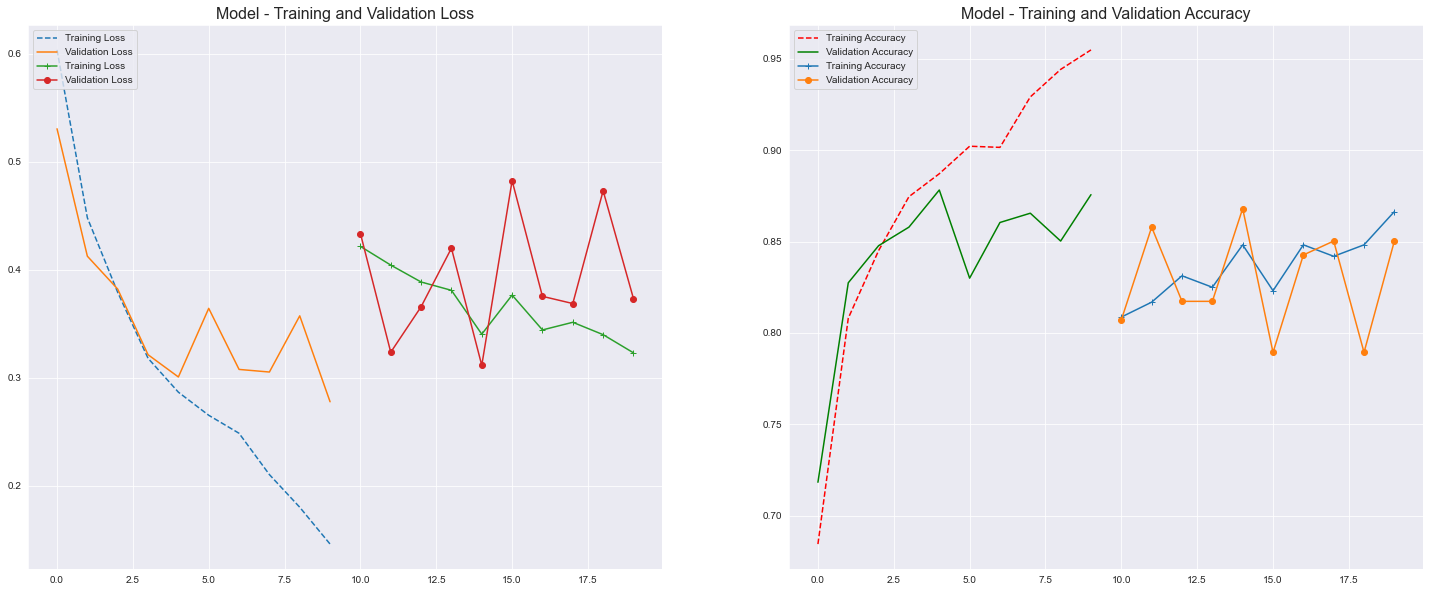

In [95]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,10))
ax1.plot(history2.history['loss'], label='Training Loss', linestyle="--")
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.plot(history3.epoch, history3.history['loss'], label='Training Loss', marker='+')
ax1.plot(history3.epoch, history3.history['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Model - Training and Validation Loss', size=16)
ax1.legend(loc="upper left")
ax2.plot(history2.history['accuracy'], label='Training Accuracy', linestyle="--", color='r')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy', color='g')
ax2.plot(history3.epoch, history3.history['accuracy'], label='Training Accuracy', marker='+')
ax2.plot(history3.epoch, history3.history['val_accuracy'], label='Validation Accuracy', marker='o')
ax2.set_title('Model - Training and Validation Accuracy', size=16)
ax2.legend(loc="upper left")
plt.show()

In [96]:
np.median(history3.history['loss'], axis=0)   

0.36398492753505707

In [97]:
np.median(history3.history['accuracy'][-5:-1], axis=0)   

0.8450438976287842

### Question 5

What is the mean of test loss for all the epochs for the model trained with augmentations?

#### Answer: 0.36398 - 0.37



### Question 6

What's the average of test accuracy for the last 5 epochs (from 6 to 10) for the model trained with augmentations?
#### Answer: 0.84504 -> 0.84

### Testing Model Prediction (from 8.12)

In [98]:
from tensorflow.keras.preprocessing.image import load_img

path = './test/dragon/0967e534-cc4b-4e91-a995-3d2407bcf08a.jpg'
img = load_img(path, target_size=(150, 150))
x = np.array(img)
X = np.array([x])
X.shape

(1, 150, 150, 3)

In [99]:
pred = model_2.predict(X)

1/1 [==============================] - 0s 331ms/step


In [101]:
pred

array([[1.]], dtype=float32)

In [104]:
pred[0]

array([1.], dtype=float32)

In [105]:
pred[0][0]

1.0

In [102]:
train_ds.class_indices

{'dino': 0, 'dragon': 1}

In [103]:
val_ds.class_indices

{'dino': 0, 'dragon': 1}

In [106]:
dict_class = val_ds.class_indices

In [107]:
[k for k, v in dict_class.items() if v == 1][0]

'dragon'